In [1]:
from fastai.vision.all import *
import fastai
import timm
import albumentations as A

# In[2]:


import torch
torch.cuda.set_device(1)

In [ ]:
import os
def create_csvValid(path):
    output_path = os.path.join(path,"..","df_test.csv")
    if (os.path.exists(output_path)):
        output_path_csv = open(output_path, "a")
    else:
        output_path_csv = open(output_path, "w")
        head = "images, class\n"
        output_path_csv.write(head)

    
    lista_archivos = list(os.walk(path))
    lista_archivos.sort()
    for carpeta in lista_archivos:
#         print(carpeta[0])
        video = carpeta[0].split(os.path.sep)[-1]
        for files in carpeta[2]:
            if "images.csv" in files:
                leer = open(os.path.join(carpeta[0],files))
                leer.readline()
                for l in leer:
                    output_path_csv.write(video+os.path.sep+"images"+os.path.sep+l)
#                     print(l)
                

In [ ]:
create_csvValid("./dataset_split_77frames/test")

In [27]:
import pandas as pd
import numpy as np

dfValid = pd.read_csv('./dataset_split_77frames/df_train.csv')

dfTest = pd.read_csv('./dataset_split_77frames/df_test.csv')


# In[5]:


# prueba = dfValid


# prueba = prueba.iloc[np.random.permutation(len(prueba))]
# prueba = prueba[0:int(len(prueba)*0.1)]
# # In[6]:
# # Aquí debería hacer dos df diferentes. Uno para entrenamiento y otro para validación. En este caso 
# # usa para entrenar el set de entrenamiento y validación. Imagino que la división la hará por programa
# # dfValid = dfValid[(dfValid.set == 'training') | (dfValid.set == 'validation')]




# # Hay que modificar esto para que haya set de validación. Hacer un vector random y que esté entre las primeras 
# # 0.1 posiciones si está se devuelve 
# def is_valid(path):
#     name = path[0]
# #     return (dfValid[dfValid['challenge_id']==name])['set'].values[0]=='validation'
#     return (dfValid[dfValid['images']==name]).values[0] in prueba.images.values
    
# # In[13]:

# def get_class(path):
#     name = path[0]
#     return (dfValid[dfValid['images']==name])['class']


In [3]:
??RandomSplitter

In [6]:
def get_dls(presize=100,size=77,M=0,bs=512):
    db = DataBlock(blocks = (ImageBlock, CategoryBlock),
             splitter=RandomSplitter(),
             get_x = ColReader(0,pref="./dataset_split_77frames/train/",suff='.jpg'),
             get_y=ColReader(1),
             item_tfms = [Resize(presize)], # CropPad(200,200)
             batch_tfms=[*aug_transforms(size=size, min_scale=0.75,do_flip=False,flip_vert=False,
                  max_rotate=0.,max_zoom=1.1, max_warp=0.05,p_affine=0.9, p_lighting=0.8), 
                         Normalize.from_stats(*imagenet_stats)])
    dls = db.dataloaders(dfValid.values,bs=bs)
    return dls

In [7]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    #EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='resnetrsRandAugLS',monitor='cohen_kappa_score'),
    ReduceLROnPlateau(patience=10)
]

In [8]:
dlsTrain3 = get_dls()


learn = Learner(dlsTrain3,timm.create_model('resnetrs50',num_classes=13,pretrained=True),
                metrics=[accuracy,CohenKappa(weights='quadratic')],cbs=callbacks,
                loss_func= LabelSmoothingCrossEntropyFlat()).to_fp16()

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,cohen_kappa_score,time
0,2.082956,3.556506,0.355241,0.650283,00:12


Better model found at epoch 0 with cohen_kappa_score value: 0.6502830090623453.


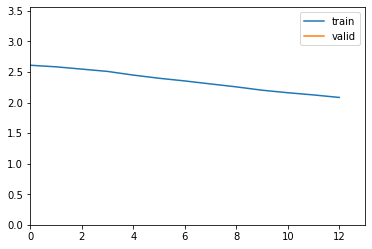

epoch,train_loss,valid_loss,accuracy,cohen_kappa_score,time
0,1.460006,1.385015,0.592068,0.809513,00:07
1,1.368221,1.360977,0.604533,0.801145,00:07
2,1.300289,1.248926,0.652691,0.820722,00:06
3,1.243195,1.130077,0.725212,0.873368,00:07
4,1.202718,1.116857,0.734844,0.856869,00:06
5,1.164336,1.086535,0.738810,0.873119,00:07
6,1.128141,1.064111,0.754674,0.874603,00:07
7,1.091804,1.063153,0.754108,0.885319,00:07
8,1.059083,1.044594,0.776204,0.901634,00:06
9,1.028840,1.090886,0.746742,0.883582,00:07


Better model found at epoch 0 with cohen_kappa_score value: 0.8095129160546735.


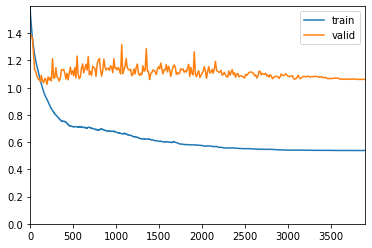

Better model found at epoch 2 with cohen_kappa_score value: 0.8207221277228778.
Better model found at epoch 3 with cohen_kappa_score value: 0.8733676188387106.
Better model found at epoch 6 with cohen_kappa_score value: 0.874602532985765.
Better model found at epoch 7 with cohen_kappa_score value: 0.8853190302901821.
Better model found at epoch 8 with cohen_kappa_score value: 0.9016340970194525.
Better model found at epoch 10 with cohen_kappa_score value: 0.9109963379193494.
Better model found at epoch 16 with cohen_kappa_score value: 0.9123086139742763.
Epoch 24: reducing lr to 5.130946485782261e-05
Better model found at epoch 26 with cohen_kappa_score value: 0.9162398710969908.
Better model found at epoch 34 with cohen_kappa_score value: 0.9166211337441762.
Epoch 34: reducing lr to 6.932747011175445e-05
Epoch 44: reducing lr to 8.983888727004283e-05
Better model found at epoch 53 with cohen_kappa_score value: 0.9190208929989968.
Epoch 54: reducing lr to 0.00011036973699904172
Epoch 6

In [9]:
learn.fine_tune(300,base_lr=3e-3)

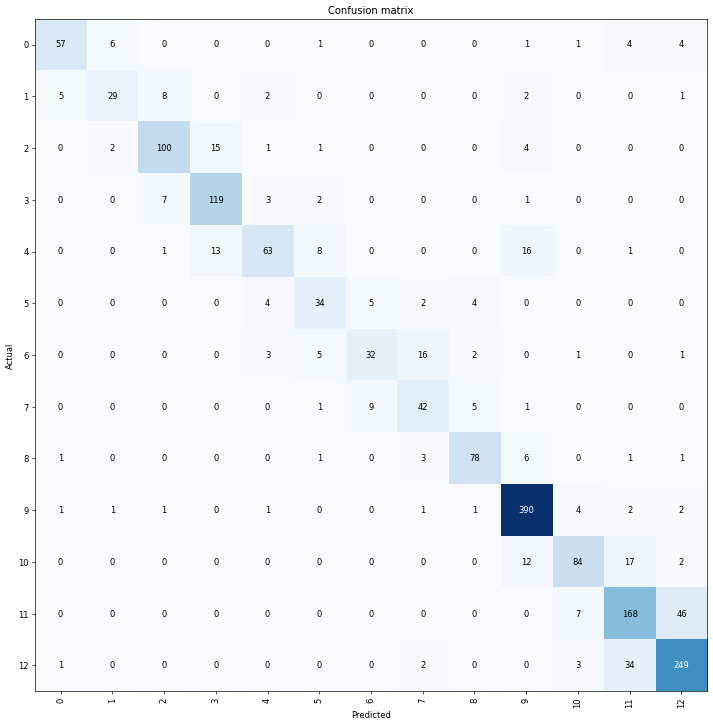

In [10]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [29]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_x = ColReader(0,pref="./dataset_split_77frames/test/",suff='.jpg'),
                 get_y=ColReader(1),
                 item_tfms = Resize(100),
                 batch_tfms=[*aug_transforms(size=77, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(dfTest.values,bs=128)



# dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),get_items=get_image_files, 
#                    splitter=GrandparentSplitter(valid_name='test'),get_y=parent_label, 
#                    item_tfms = Resize(512),batch_tfms=[*aug_transforms(size=256, min_scale=0.75), 
#                    Normalize.from_stats(*imagenet_stats)])
# dlsTest = dbTest.dataloaders("./dataset_split_77frames/df_test.csv",bs=32)

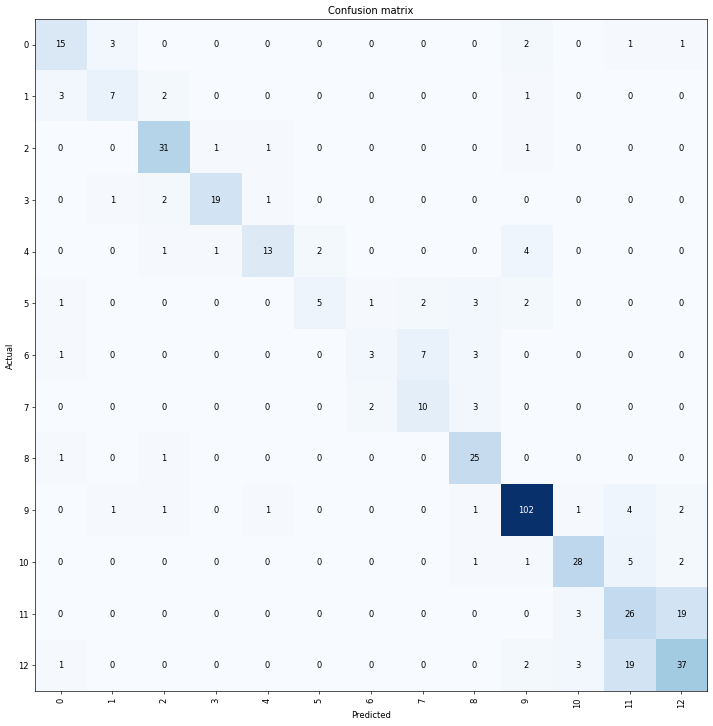

In [30]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [34]:
# learn.validate()

/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


IndexError: list index out of range

In [35]:
# learn.export(fname='resnetrsRandAugLS_77frames.pkl')

PicklingError: Can't pickle typing.Callable[..., typing.Any]: it's not the same object as typing.Callable

In [36]:
learn1 = Learner(dlsTrain3,timm.create_model('resnetrs50',num_classes=13,pretrained=True),
                metrics=[accuracy,CohenKappa(weights='quadratic')]).to_fp16()

In [37]:
learn1.load("resnetrsRandAugLS")
# Para cargar luego este modelo necesitas también ejecutar todo lo del learner que tenemos menos el entrenamiento

/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [38]:
learn1.export("resnetrsRandAugLS_77frames.pkl")


In [39]:
learn1.validate()

(#3) [0.6961913108825684,0.8186968564987183,0.9341236914082227]

In [41]:
preds,gt = learn1.tta()

In [47]:
from sklearn.metrics import accuracy_score, top_k_accuracy_score
accuracy_score(np.argmax(preds,axis=1),gt)

ImportError: cannot import name 'top_k_accuracy_score'